<a href="https://colab.research.google.com/github/rrahul2203/Deep-learning-Computer-Vision/blob/main/unet_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

In [2]:
def double_conv(in_c, out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size=3),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c, out_c, kernel_size=3),
      nn.ReLU(inplace=True),
  )
  return conv

def crop_image(tensor, target_tensor):
  target_size = target_tensor.size()[2]
  tensor_size = tensor.size()[2]
  delta = (tensor_size - target_size)//2
  return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]

In [3]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.down_conv_1 = double_conv(1, 64)
    self.down_conv_2 = double_conv(64, 128)
    self.down_conv_3 = double_conv(128, 256)
    self.down_conv_4 = double_conv(256, 512)
    self.down_conv_5 = double_conv(512, 1024)
    self.trans_conv_1 = nn.ConvTranspose2d(in_channels = 1024, out_channels=512, kernel_size = 2, stride=2)
    self.up_conv_1 = double_conv(1024, 512)
    self.trans_conv_2 = nn.ConvTranspose2d(in_channels = 512, out_channels=256, kernel_size = 2, stride=2)
    self.up_conv_2 = double_conv(512, 256)
    self.trans_conv_3 = nn.ConvTranspose2d(in_channels = 256, out_channels=128, kernel_size = 2, stride=2)
    self.up_conv_3 = double_conv(256, 128)
    self.trans_conv_4 = nn.ConvTranspose2d(in_channels = 128, out_channels=64, kernel_size = 2, stride=2)
    self.up_conv_4 = double_conv(128, 64)
    self.out = nn.Conv2d(64, 2, kernel_size=1)


  def forward(self, image):
    # bs, c, h, w
    # encoder
    x1 = self.down_conv_1(image)
    print(x1.size())
    x2 = self.max_pool_2x2(x1)
    x3 = self.down_conv_2(x2)
    x4 = self.max_pool_2x2(x3)
    x5 = self.down_conv_3(x4)
    x6 = self.max_pool_2x2(x5)
    x7 = self.down_conv_4(x6)
    x8 = self.max_pool_2x2(x7)
    x9 = self.down_conv_5(x8)
    print(x9.size())

    # decoder 
    x = self.trans_conv_1(x9)
    xcopy = crop_image(x7, x)
    y = self.up_conv_1(torch.cat([xcopy, x],1))

    x = self.trans_conv_2(y)
    xcopy = crop_image(x5, x)
    y = self.up_conv_2(torch.cat([xcopy, x],1))

    x = self.trans_conv_3(y)
    xcopy = crop_image(x3, x)
    y = self.up_conv_3(torch.cat([xcopy, x],1))

    x = self.trans_conv_4(y)
    xcopy = crop_image(x1, x)
    y = self.up_conv_4(torch.cat([xcopy, x],1))

    y = self.out(y)
    print(y.size())

In [4]:
image = torch.rand((1,1,572,572))
model = UNet()
print(model(image))

torch.Size([1, 64, 568, 568])
torch.Size([1, 1024, 28, 28])
torch.Size([1, 2, 388, 388])
None


### Import Libraries

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

### Load dataset from TFDS

In [6]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDU0HMQ/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDU0HMQ/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='~/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        '

### Data preprocessing

In [7]:
def resize(input_image, input_mask):
  input_image = tf.image.resize(input_image, (128, 128), method="nearest")
  input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
  return input_image, input_mask

def augment(input_image, input_mask):
  if tf.random.uniform(()) > 0.5:
    # Random flipping of the image and mask
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  return input_image, input_mask

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [8]:
def load_image_train(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = augment(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

def load_image_test(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

Create train, validation and test batches. Note we split the original `test_dataset` into validation and test batches.

In [9]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

### Data Visualization

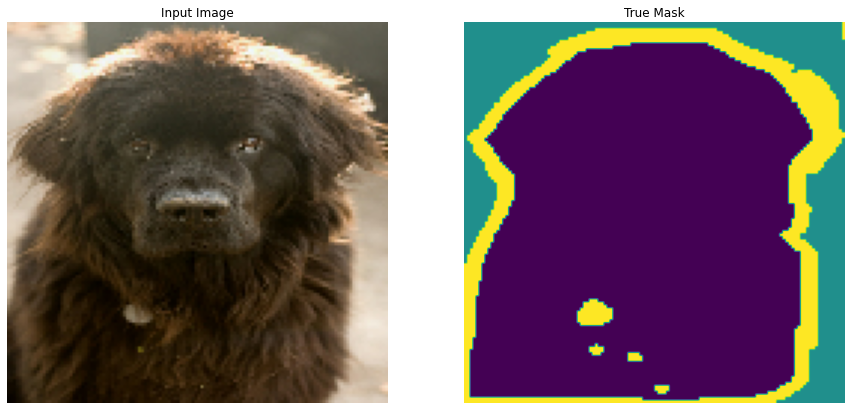

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ["Input Image", "True Mask", "Predicted Mask"]
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

## U-Net Building blocks
Create the building blocks for making the components U-Net model. 

In [12]:
def double_conv_block(x, n_filters):
  # Conv2D then ReLU activation
  x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Conv2D then ReLU activation
  x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  return x

def downsample_block(x, n_filters):
  f = double_conv_block(x, n_filters)
  p = layers.MaxPool2D(2)(f)
  p = layers.Dropout(0.3)(p)
  return f, p

def upsample_block(x, conv_features, n_filters):
  # upsample
  x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
  # concatenate
  x = layers.concatenate([x, conv_features])
  # dropout
  x = layers.Dropout(0.3)(x)
  # Conv2D twice with ReLU activation
  x = double_conv_block(x, n_filters)
  return x

## Build the U-Net Model

In [13]:
def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [14]:
unet_model = build_unet_model()

In [15]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

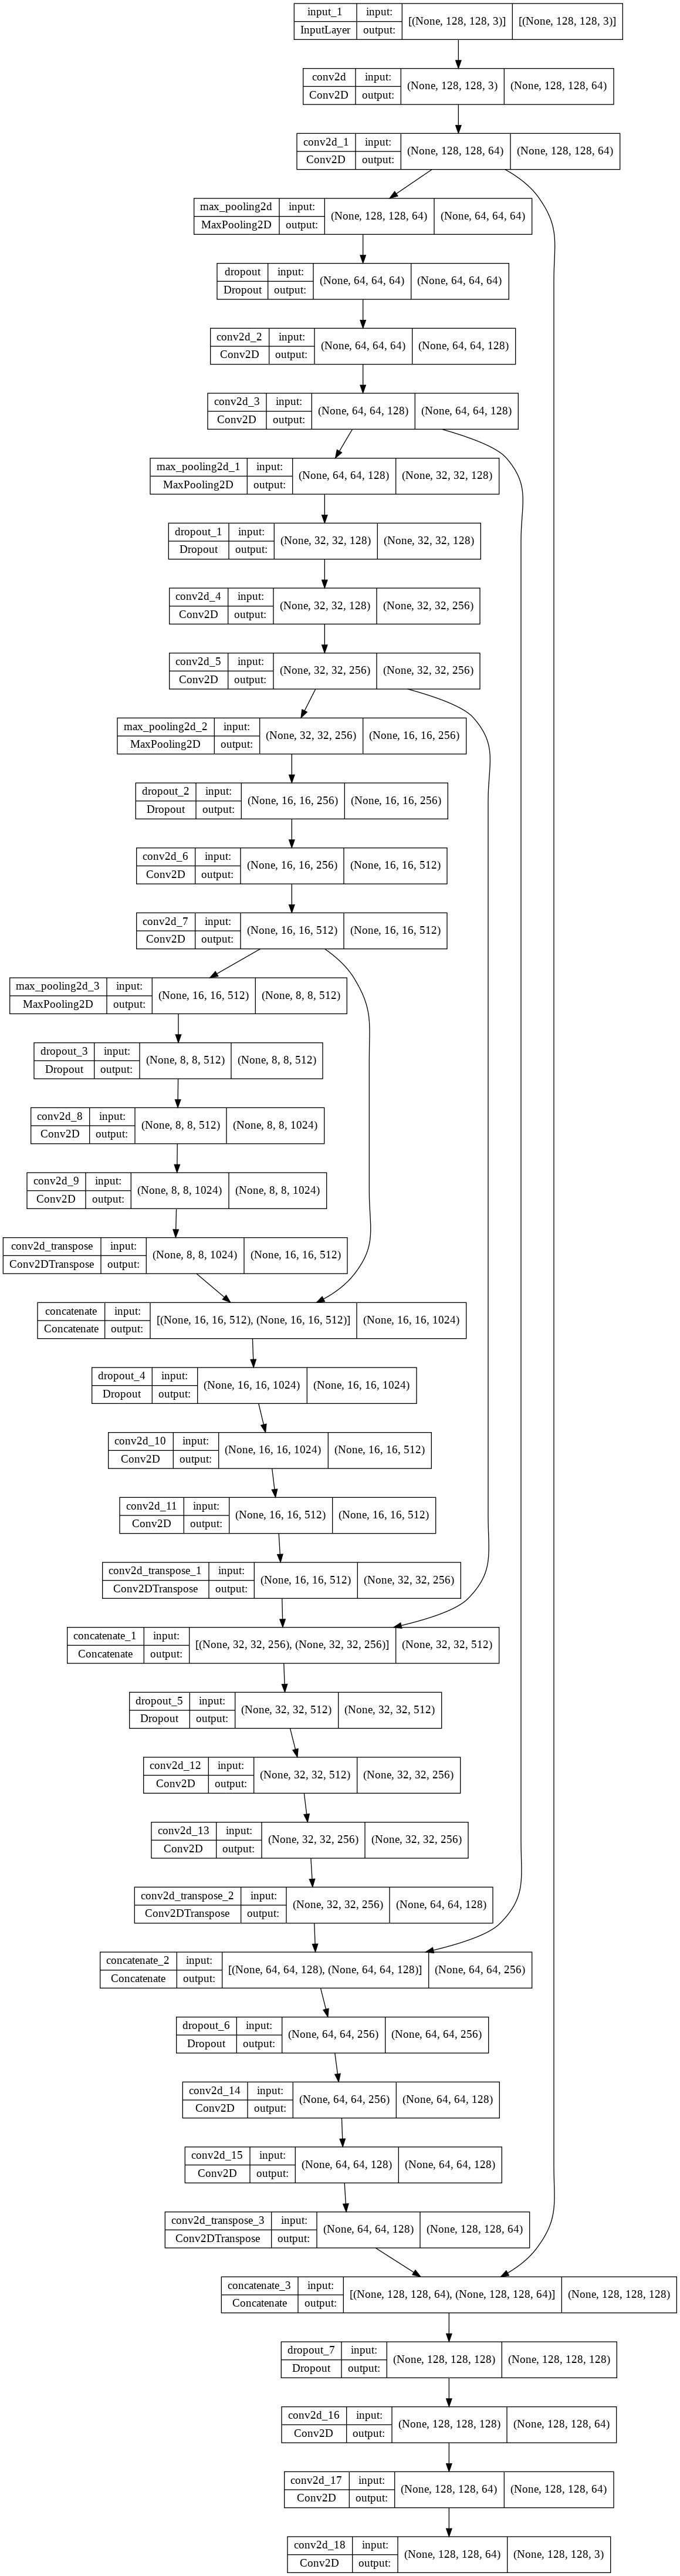

In [16]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

## Compile and Train U-Net

In [17]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),loss="sparse_categorical_crossentropy",metrics="accuracy")

In [18]:
NUM_EPOCHS = 20
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,epochs=NUM_EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 89s 1s/step - loss: 0.9320 - accuracy: 0.5780 - val_loss: 0.8691 - val_accuracy: 0.5872
Epoch 2/20
57/57 [==============================] - 69s 1s/step - loss: 0.8102 - accuracy: 0.6211 - val_loss: 0.7267 - val_accuracy: 0.7009
Epoch 3/20
57/57 [==============================] - 62s 1s/step - loss: 0.6624 - accuracy: 0.7303 - val_loss: 0.6036 - val_accuracy: 0.7604
Epoch 4/20
57/57 [==============================] - 62s 1s/step - loss: 0.5919 - accuracy: 0.7650 - val_loss: 0.5448 - val_accuracy: 0.7823
Epoch 5/20
57/57 [==============================] - 62s 1s/step - loss: 0.5271 - accuracy: 0.7941 - val_loss: 0.4749 - val_accuracy: 0.8146
Epoch 6/20
57/57 [==============================] - 62s 1s/step - loss: 0.4934 - accuracy: 0.8083 - val_loss: 0.5007 - val_accuracy: 0.8043
Epoch 7/20
57/57 [==============================] - 62s 1s/step - loss: 0.4644 - accuracy: 0.8207 - val_loss: 0.4715 - val_accuracy: 0.8183
Epoch 8/20
57/57 [==

## Learning curve from model history

In [19]:
def display_learning_curves(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs_range = range(NUM_EPOCHS)

  fig = plt.figure(figsize=(12,6))

  plt.subplot(1,2,1)
  plt.plot(epochs_range, acc, label="train accuracy")
  plt.plot(epochs_range, val_acc, label="validataion accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")

  plt.subplot(1,2,2)
  plt.plot(epochs_range, loss, label="train loss")
  plt.plot(epochs_range, val_loss, label="validataion loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

  fig.tight_layout()
  plt.show()

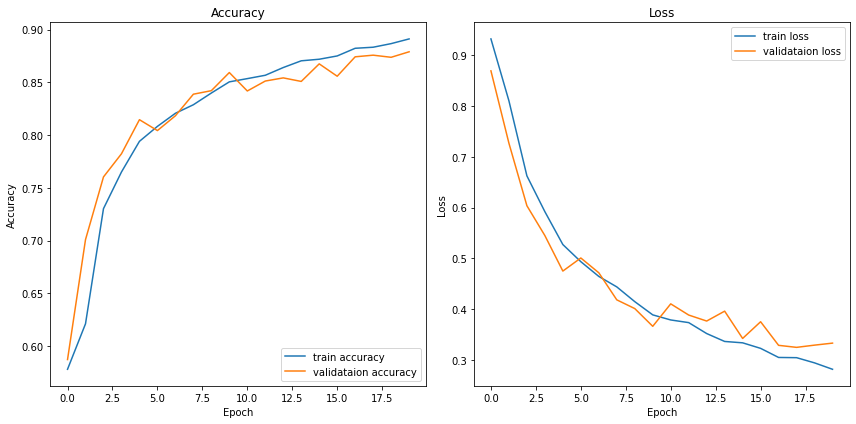

In [20]:
# Display learning curves 
display_learning_curves(unet_model.history)

## Predictions with U-Net model
Let's try the trained U-Net model on a few samples from the test dataset.

In [21]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [22]:
count = 0
for i in test_batches:
  count +=1

print("number of batches:", count)

number of batches: 11


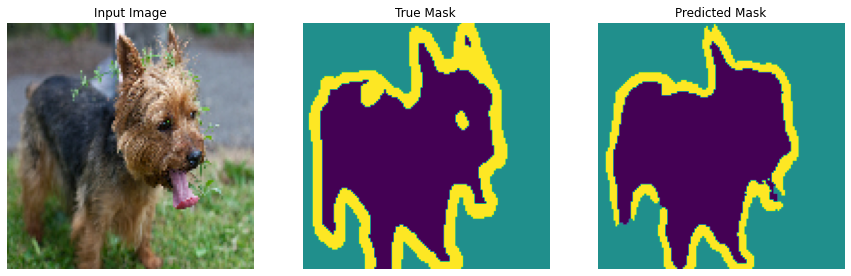

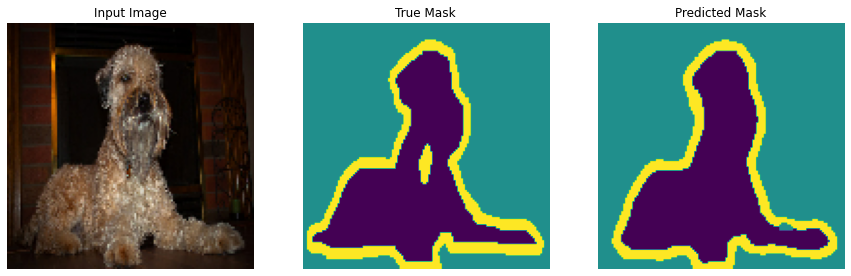

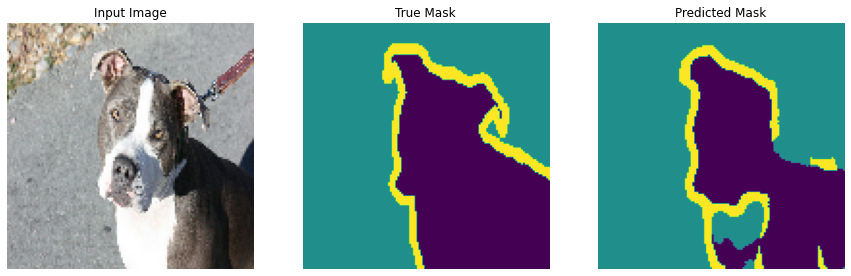

In [23]:
show_predictions(test_batches.skip(5), 3)